In [68]:
import matplotlib.pyplot as plt
import torchvision
from pathlib import Path
import torch

from torch import nn
from torchvision import transforms
from scripts import data_setup, engine
import torchinfo


In [69]:
#VGG16, GoogLenet, AlexNet, ResNeXt, efficientnet and DenseNet are the architectures

In [70]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [71]:
data_path = Path("data/")
image_path = data_path / "soil_low_med_high"

In [72]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [73]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

In [ ]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=4) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x2a12c461a60>,
 ['high', 'low', 'medium'])

In [75]:
# OLD: Setup the model with pretrained weights and send it to the target device (this was prior to torchvision v0.13)
# model = torchvision.models.efficientnet_b0(pretrained=True).to(device) # OLD method (with pretrained=True)

# NEW: Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights 
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

#model # uncomment to output (it's very long)

In [76]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False

In [77]:
# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True), 
    nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [78]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [79]:

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=20,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  5%|▌         | 1/20 [00:20<06:24, 20.25s/it]

Epoch: 1 | train_loss: 1.1024 | train_acc: 0.3444 | test_loss: 1.1341 | test_acc: 0.3200


 10%|█         | 2/20 [00:39<05:54, 19.71s/it]

Epoch: 2 | train_loss: 1.0823 | train_acc: 0.4000 | test_loss: 1.1082 | test_acc: 0.3600


 15%|█▌        | 3/20 [00:58<05:30, 19.43s/it]

Epoch: 3 | train_loss: 1.0325 | train_acc: 0.4778 | test_loss: 1.0103 | test_acc: 0.5200


 20%|██        | 4/20 [01:19<05:20, 20.05s/it]

Epoch: 4 | train_loss: 1.0149 | train_acc: 0.4778 | test_loss: 1.0361 | test_acc: 0.4400


 25%|██▌       | 5/20 [01:44<05:26, 21.77s/it]

Epoch: 5 | train_loss: 0.9853 | train_acc: 0.5222 | test_loss: 1.0784 | test_acc: 0.4000


 30%|███       | 6/20 [02:08<05:15, 22.55s/it]

Epoch: 6 | train_loss: 0.9794 | train_acc: 0.5333 | test_loss: 1.0928 | test_acc: 0.4400


 35%|███▌      | 7/20 [02:31<04:53, 22.60s/it]

Epoch: 7 | train_loss: 0.9372 | train_acc: 0.6556 | test_loss: 1.0494 | test_acc: 0.3600


 40%|████      | 8/20 [03:06<05:19, 26.60s/it]

Epoch: 8 | train_loss: 0.9847 | train_acc: 0.5444 | test_loss: 1.0363 | test_acc: 0.4400


 45%|████▌     | 9/20 [03:40<05:19, 29.03s/it]

Epoch: 9 | train_loss: 0.9597 | train_acc: 0.6111 | test_loss: 1.0102 | test_acc: 0.4400


 50%|█████     | 10/20 [04:19<05:19, 31.94s/it]

Epoch: 10 | train_loss: 0.8990 | train_acc: 0.6444 | test_loss: 1.7095 | test_acc: 0.4400


 55%|█████▌    | 11/20 [04:57<05:05, 33.91s/it]

Epoch: 11 | train_loss: 0.9218 | train_acc: 0.6667 | test_loss: 2.4245 | test_acc: 0.3600


 60%|██████    | 12/20 [05:34<04:38, 34.85s/it]

Epoch: 12 | train_loss: 0.9157 | train_acc: 0.6444 | test_loss: 0.9876 | test_acc: 0.4800


 65%|██████▌   | 13/20 [06:13<04:13, 36.21s/it]

Epoch: 13 | train_loss: 0.8922 | train_acc: 0.6667 | test_loss: 0.9976 | test_acc: 0.4800


 70%|███████   | 14/20 [06:51<03:39, 36.59s/it]

Epoch: 14 | train_loss: 0.8987 | train_acc: 0.7111 | test_loss: 0.9603 | test_acc: 0.4800


 75%|███████▌  | 15/20 [07:29<03:04, 36.92s/it]

Epoch: 15 | train_loss: 0.8680 | train_acc: 0.6222 | test_loss: 1.1379 | test_acc: 0.3600


 80%|████████  | 16/20 [08:07<02:29, 37.29s/it]

Epoch: 16 | train_loss: 0.8773 | train_acc: 0.6778 | test_loss: 0.9707 | test_acc: 0.5600


 85%|████████▌ | 17/20 [08:45<01:52, 37.54s/it]

Epoch: 17 | train_loss: 0.8896 | train_acc: 0.6333 | test_loss: 0.9374 | test_acc: 0.5600


 90%|█████████ | 18/20 [09:24<01:15, 37.90s/it]

Epoch: 18 | train_loss: 0.8948 | train_acc: 0.6667 | test_loss: 1.0744 | test_acc: 0.5200


 95%|█████████▌| 19/20 [10:02<00:37, 38.00s/it]

Epoch: 19 | train_loss: 0.8639 | train_acc: 0.6333 | test_loss: 0.9184 | test_acc: 0.4800


100%|██████████| 20/20 [10:40<00:00, 32.02s/it]

Epoch: 20 | train_loss: 0.9215 | train_acc: 0.6222 | test_loss: 0.9295 | test_acc: 0.5600
[INFO] Total training time: 640.362 seconds


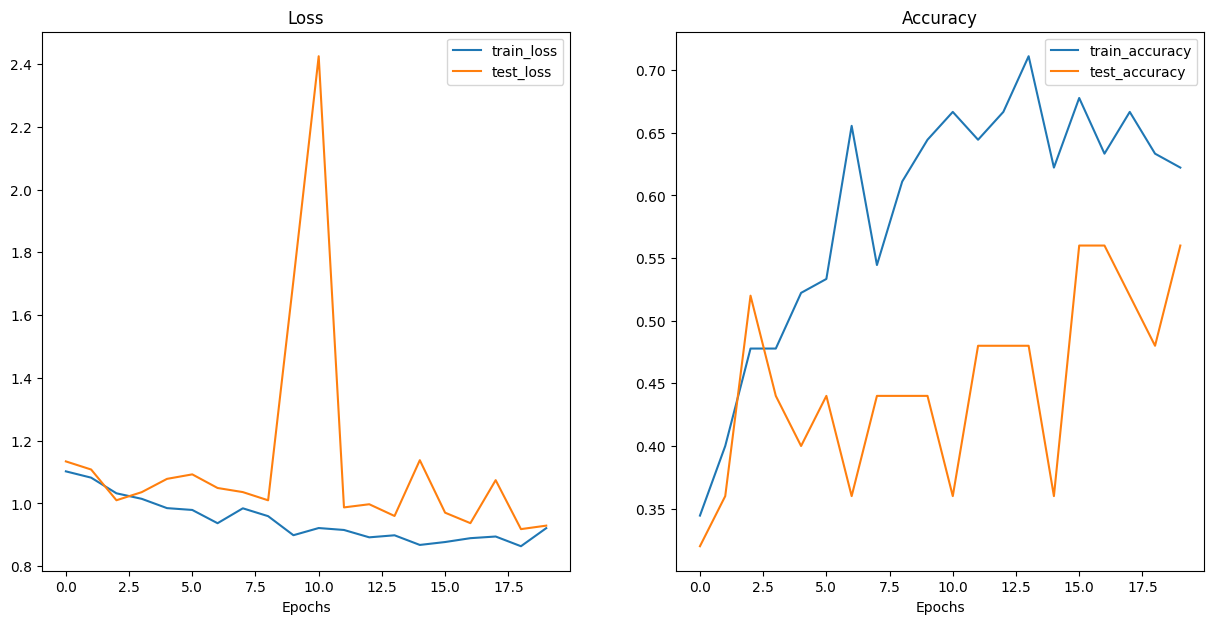

In [80]:
from scripts.helper_functions import plot_loss_curves

plot_loss_curves(results)